<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-DavRo24/blob/main/Sep/Ejercicio-30-09-23/MCMC-metodo-07-octubre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Establecer una semilla para la generación de números aleatorios
np.random.seed(42)

# Cargar datos desde el archivo
file = "/content/drive/MyDrive/Machine-Learning-2023/olympic100m_men.txt"
datos = np.loadtxt(file, delimiter=',').T
x = datos[0]
y = datos[1]
sigma = np.std(y)  # Desviación estándar de los errores
# Normalizar los datos
x_mean = np.mean(x)
x_std = np.std(x)
y_mean = np.mean(y)
y_std = np.std(y)

x_normalized = (x - x_mean) / x_std
y_normalized = (y - y_mean) / y_std
sigma = np.std(y_normalized)  # Actualizamos la desviación estándar de los errores

In [9]:
# Función para calcular la probabilidad de la distribución normal
def normal_pdf(x, mean, variance):
    return np.exp(-(x - mean)**2 / (2 * variance)) / np.sqrt(2 * np.pi * variance)

# Función para calcular el logaritmo de la verosimilitud
def log_likelihood(theta, x, y, sigma):
    y_pred = theta[0] + theta[1] * x
    error = y - y_pred
    return -0.5 * np.sum(error**2) / (sigma**2)

# Función para el paso de Metropolis-Hastings
def metropolis_step(theta_current, proposal_sigma, x, y, sigma):
    theta_proposed = theta_current + np.random.normal(0, proposal_sigma, size=len(theta_current))

    # Calcular el logaritmo de la verosimilitud para los parámetros propuestos y actuales
    log_likelihood_current = log_likelihood(theta_current, x, y, sigma)
    log_likelihood_proposed = log_likelihood(theta_proposed, x, y, sigma)

    # Calcular la razón de aceptación
    acceptance_ratio = np.exp(log_likelihood_proposed - log_likelihood_current)

    # Aceptar o rechazar el nuevo valor de theta
    if np.random.rand() < acceptance_ratio:
        return theta_proposed
    else:
        return theta_current

# Parámetros del MCMC
num_samples = 100000
burn_in = 1000
proposal_sigma = 0.01

# Número de cadenas
num_chains = 4

# Listas para almacenar las muestras de cada cadena
theta_samples_list = []

# Ejecutar el MCMC para cada cadena
for chain in range(num_chains):
    # Inicialización de los parámetros para cada cadena
    theta_current = np.array([0.0, 0.0])

    # Lista para almacenar las muestras de la cadena actual
    theta_samples = []

    # Ejecutar el MCMC para la cadena actual
    for _ in range(num_samples):
        theta_current = metropolis_step(theta_current, proposal_sigma, x_normalized, y_normalized, sigma)
        theta_samples.append(theta_current)

    # Descartar las muestras de "burn-in" y agregar a la lista de muestras
    theta_samples = np.array(theta_samples[burn_in:])
    theta_samples_list.append(theta_samples)

# Estimar los valores finales de los parámetros para cada cadena
theta_means = [np.mean(theta_samples, axis=0) for theta_samples in theta_samples_list]

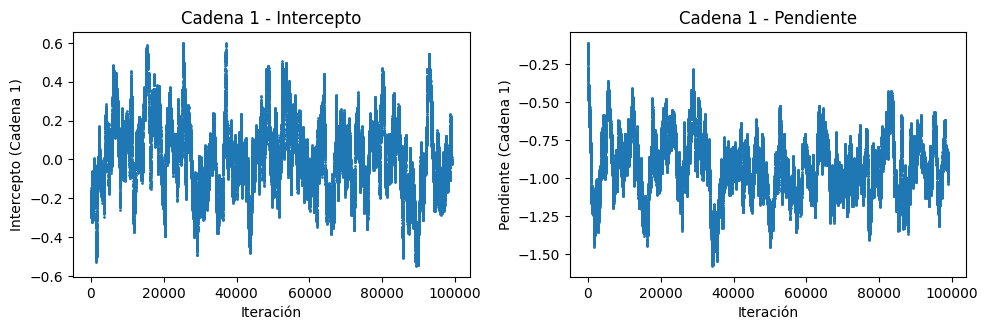

In [10]:
plt.figure(figsize=(10, 6))

# Graficar la primera cadena
plt.subplot(2, 2, 1)
plt.scatter(range(len(theta_samples_list[0])), theta_samples_list[0][:, 0], s=1)
plt.xlabel('Iteración')
plt.ylabel('Intercepto (Cadena 1)')
plt.title('Cadena 1 - Intercepto')

plt.subplot(2, 2, 2)
plt.scatter(range(len(theta_samples_list[0])), theta_samples_list[0][:, 1], s=1)
plt.xlabel('Iteración')
plt.ylabel('Pendiente (Cadena 1)')
plt.title('Cadena 1 - Pendiente')

# Puedes repetir estos gráficos para las otras cadenas (2, 3 y 4) cambiando los índices correspondientes

plt.tight_layout()
plt.show()

In [11]:
# Pasos 1 y 2: Calcular estadísticas resumen para cada cadena
means = [np.mean(chain_samples, axis=0) for chain_samples in theta_samples_list]
variances_within = [np.var(chain_samples, axis=0) for chain_samples in theta_samples_list]

# Paso 3: Calcular la varianza entre cadenas y la varianza dentro de cadenas
mean_within = np.mean(means, axis=0)
variance_between = np.var(means, axis=0, ddof=1)
mean_within_var = np.mean(variances_within, axis=0)

# Paso 4: Calcular R-hat para cada parámetro
r_hat = np.sqrt(variance_between / mean_within_var)

# Paso 5: Evaluar convergencia
if all(r < 1.1 for r in r_hat):
    print("Convergencia: Todos los R-hat son menores que 1.1")
else:
    print("Falta de convergencia: Al menos un R-hat es mayor o igual a 1.1")

# Paso 6: Visualizar trazas y distribuciones para inspeccionar visualmente la convergencia

Convergencia: Todos los R-hat son menores que 1.1


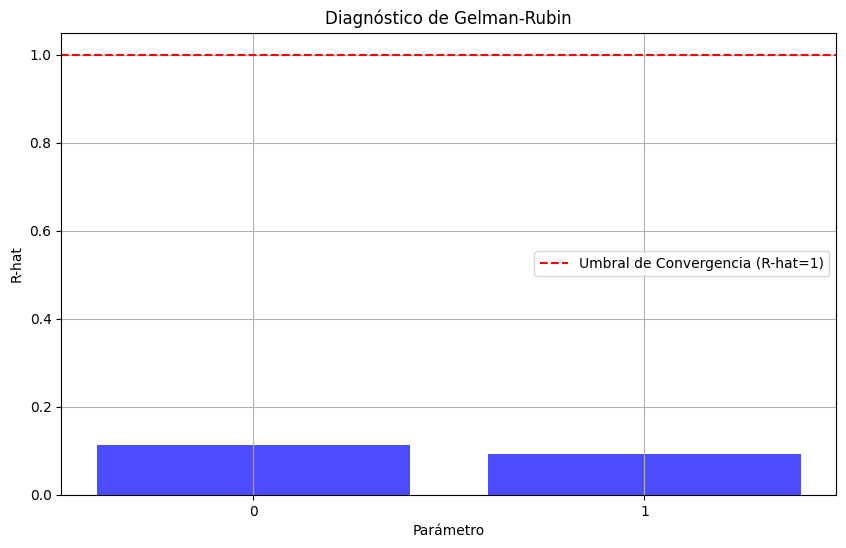

In [12]:
# Crear un gráfico de barras para los valores de R-hat
parameters = np.arange(len(r_hat))
r_hat_values = np.array(r_hat)

plt.figure(figsize=(10, 6))
plt.bar(parameters, r_hat_values, color='b', alpha=0.7)
plt.axhline(y=1.0, color='r', linestyle='--', label='Umbral de Convergencia (R-hat=1)')
plt.xlabel('Parámetro')
plt.ylabel('R-hat')
plt.title('Diagnóstico de Gelman-Rubin')
plt.xticks(parameters)
plt.legend()
plt.grid(True)
plt.show()
